In [1]:
!pip install matplotlib

In [1]:
import json
import logging
import os
import pandas as pd
import re
import structlog
import sys
from datasets import Dataset

structlog.configure(logger_factory=structlog.stdlib.LoggerFactory())
logging.basicConfig(format="%(message)s", stream=sys.stderr, level=logging.INFO)
log = structlog.getLogger()

In [45]:
class ParseFB:
    def __init__(self, bot_sender):
        self.bot_sender = bot_sender
        self.data = None
        self.model_data = pd.DataFrame()
        self.tokenized_data = None
        self.huggingface_dataset = None


    @staticmethod
    def fix_string(s):
        out_s = re.sub(r'[\xc2-\xf4][\x80-\xbf]+', lambda m: m.group(0).encode('latin1').decode('utf8'), s)
        return out_s

    def parse_messages(self, messages):
        data = pd.DataFrame.from_records(messages)
        data['datetime'] = pd.to_datetime(data['timestamp_ms'], unit='ms')
        data = data.sort_values(by='datetime').reset_index(drop=True)
        data['content'].fillna("", inplace=True)
        data['content'] = data['content'].apply(lambda s: self.fix_string(s))

        def concatenate_with_newline(group):
            return '\n'.join(group)

        # Concatenate strings in the 'Text' column for each block of sequential identical 'ID' values using \n as separator
        data = data.groupby((data['sender_name'] != data['sender_name'].shift(1)).cumsum()).agg({'content': concatenate_with_newline, 'sender_name': 'first'}).reset_index(drop=True)
        if len(data) == 1:
            return pd.DataFrame()

        if data.iloc[0]['sender_name'] == self.bot_sender:
            row = pd.DataFrame({"content": [""], "sender_name": [data.iloc[1]['sender_name']]})
            data = pd.concat([row, data], axis=0, ignore_index=True)

        if data.iloc[-1]['sender_name'] != self.bot_sender:
            row = pd.DataFrame({"content": [""], "sender_name": [self.bot_sender]})
            data = pd.concat([data, row], axis=0, ignore_index=True)

        return data

    def parse_data(self, path='data/fb/inbox'):
        chats = os.listdir(path)
        chat_df = pd.DataFrame()
        for chat in chats:
            if chat != ".DS_Store":
                for file in os.listdir(f"{path}/{chat}"):
                    if file.endswith(".json"):
                        data_json = json.load(open(f"{path}/{chat}/{file}", "r", encoding='latin1'))
                        df = self.parse_messages(data_json["messages"])
                        chat_df = pd.concat([chat_df, df], axis=0)
        log.info("Finished to parse all data")
        self.data = chat_df

    def build_model_data(self, path='data/fb/inbox'):
        if self.data is None:
            self.parse_data(path)
        for idx in range(0, len(self.data),2):
            df = pd.DataFrame({"content": ["<startofstring> " + self.data.iloc[idx]['content'] + " <bot> " + self.data.iloc[idx+1]['content'] + " <endofstring>"]})
            self.model_data = pd.concat([self.model_data, df], ignore_index=True)

        log.info("Finished to build model data")


    def build_huggingface_dataset(self, path='data/fb/inbox'):
        if self.model_data.empty:
            self.build_model_data(path)

        self.huggingface_dataset = Dataset.from_pandas(self.model_data).train_test_split(test_size=0.2, shuffle=False)
        log.info("Finished to build huggingface dataset")


    def tokenize_data(self, tokenizer):
        def preprocess_function(example):
            return tokenizer(example['content'])

        self.tokenized_data = self.huggingface_dataset.map(
            preprocess_function,
            batched=True,
            num_proc=4,
            remove_columns=self.huggingface_dataset["train"].column_names,
        )


## Parse data to dataframe. Already aggregating consecutive texts from same sender as single message. 

In [46]:
bot_sender = "Felipe Vianna"
parser = ParseFB(bot_sender)
parser.parse_data()
parser.data.head()

2023-10-10 13:16:36 [info     ] Finished to parse all data


,content,sender_name
0,Hello hello how are you? How is Vhristmas holi...,Adel Adelova
1,"Christmas is long gone, but holidays are going...",Felipe Vianna
2,"Hell yeah, I need to turn back to my normal sc...",Adel Adelova
3,Yes! I usually sleep at 2.. but as I’m not wor...,Felipe Vianna
4,Wooow\nYou are like that night bird :)\nSo you...,Adel Adelova


### Make the data with tokens to mark start of message, start of bot and end of message for training dataset

In [47]:
parser.build_model_data()
parser.model_data.head()

2023-10-10 13:16:38 [info     ] Finished to build model data


,content
0,<startofstring> Hello hello how are you? How i...
1,"<startofstring> Hell yeah, I need to turn back..."
2,<startofstring> Wooow\nYou are like that night...
3,<startofstring> Hmm thats the question... I do...
4,<startofstring> Wooow niiice so New Year inSlo...


### stats on lenght of text

In [48]:
df = parser.model_data.copy()

In [49]:
df['length'] = df['content'].apply(lambda x: len(x))

<Axes: >

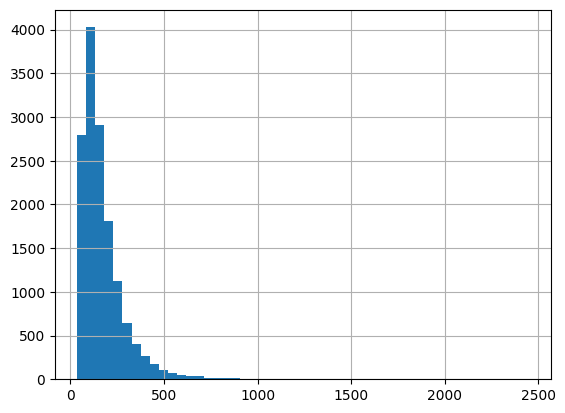

In [50]:
df['length'].hist(bins=50)

## Create huggingface dataset

In [51]:
parser.build_huggingface_dataset()

2023-10-10 13:16:39 [info     ] Finished to build huggingface dataset


In [52]:
parser.huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['content'],
        num_rows: 11633
    })
    test: Dataset({
        features: ['content'],
        num_rows: 2909
    })
})

In [63]:
parser.huggingface_dataset['train']

Dataset({
    features: ['content'],
    num_rows: 11633
})

## Tokenize data

In [54]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<pad>", 
                                "bos_token": "<startofstring>",
                                "eos_token": "<endofstring>"})
tokenizer.add_tokens(["<bot>"])

1

In [55]:
parser.tokenize_data(tokenizer)

Map (num_proc=4):   0%|          | 0/11633 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2909 [00:00<?, ? examples/s]

In [56]:
print(len(parser.tokenized_data['train'][0]['input_ids']))
parser.tokenized_data['train'][0]

43


{'input_ids': [50258,
  18435,
  23748,
  703,
  389,
  345,
  30,
  1374,
  318,
  569,
  71,
  1585,
  5356,
  9912,
  1016,
  30,
  220,
  50260,
  6786,
  318,
  890,
  3750,
  11,
  475,
  17122,
  389,
  1016,
  880,
  796,
  60,
  198,
  26738,
  7213,
  2739,
  777,
  1528,
  30,
  304,
  258,
  258,
  71,
  220,
  50259],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [57]:
train_data = parser.tokenized_data['train'].to_pandas()

In [58]:
train_data['input_ids'][0]

array([50258, 18435, 23748,   703,   389,   345,    30,  1374,   318,
         569,    71,  1585,  5356,  9912,  1016,    30,   220, 50260,
        6786,   318,   890,  3750,    11,   475, 17122,   389,  1016,
         880,   796,    60,   198, 26738,  7213,  2739,   777,  1528,
          30,   304,   258,   258,    71,   220, 50259], dtype=int32)

### Stats on tokenized data

In [59]:
df = train_data.copy()

In [60]:
df['length'] = df['input_ids'].apply(lambda x: len(x))

<Axes: >

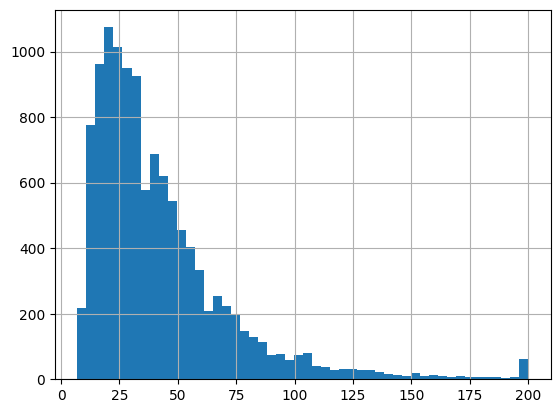

In [61]:
df['length'].clip(0,200).hist(bins=50)

In [64]:
block_size = 64


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [65]:
lm_dataset = parser.tokenized_data.map(group_texts, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/11633 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2909 [00:00<?, ? examples/s]

In [66]:
lm_dataset['train'][0]

{'input_ids': [50258,
  18435,
  23748,
  703,
  389,
  345,
  30,
  1374,
  318,
  569,
  71,
  1585,
  5356,
  9912,
  1016,
  30,
  220,
  50260,
  6786,
  318,
  890,
  3750,
  11,
  475,
  17122,
  389,
  1016,
  880,
  796,
  60,
  198,
  26738,
  7213,
  2739,
  777,
  1528,
  30,
  304,
  258,
  258,
  71,
  220,
  50259,
  50258,
  5783,
  10194,
  11,
  314,
  761,
  284,
  1210,
  736,
  284,
  616,
  3487,
  7269,
  11,
  5521,
  318,
  2406,
  2582,
  14373,
  198,
  1870],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [50258,
  18435,
  23748,
  703,
  389,
  345,
  30,
  1374,
  318,
  569,
  71,
  1585,
  5356,
  9912,
  1016,
  30,
  220,
  50260,
  6786,
  318,
  890,
 